<a href="https://colab.research.google.com/github/Andress11/KMeans-SAM/blob/main/KMeans_SAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!git clone https://github.com/Andress11/KMeans-SAM
!pip install wget
!pip install spectral

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-1ksag40w
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-1ksag40w
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36586 sha256=05a2ec0b41fc4a1569291d004e7322c7302c7f6065b0963e2693f29aebb950dd
  Stored in directory: /tmp/pip-ephem-wheel-cache-q6nc0gf0/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
Cloning into 'KMeans-SAM'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 55 (delta 24), reused 33 (delta 12), pack-reused 0
Receiving objects: 100% (55/55), 17.83 KiB |

In [2]:
mv /content/KMeans-SAM/* .

In [3]:
import KMeans_SAM as KMS
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

#<center> LECTURA  DE IMAGENES <center>

La función ***imread*** extrae la información dependiendo el tipo de imagen que entre:

* En imagenes **Hiperespectrales** se debe indicar la dirección del archivo .hdr y adicionalmente indicar que es una imagen hiperespectral mediante el segundo paramétro "HSI".

El resultado de leer una HSI se entrega en tres variables (**hsi,rgb,wl**) la primera es el hypercube generado por la imagen, el segundo es un datacubo que se genera mediate tres bandas espectrales de la HSI y el tercero son los valores de la longitud de onda.

* En imagenes **RGB** se debe indicar la dirección del archivo .jpg o .png y adicionalmente indicar que es una imagen RGB mediante el segundo paramétro "RGB".

El resultado de leer una HSI se entrega en una variable (**rgb**) la cual es un datacubo que entrega la imagen RGB

#<center> LECTURA  DE IMAGENES HIPERESPECTRALES <center>

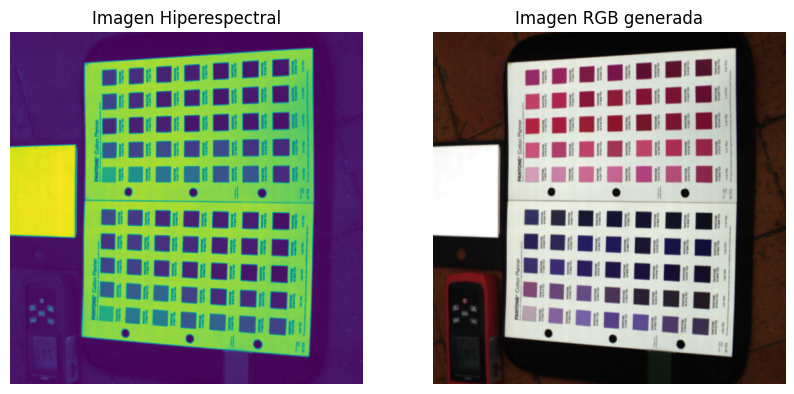

In [6]:
hsi,rgb,_ = KMS.imread("/content/drive/MyDrive/Proyecto_Investigación/Pantone_imagenes/MORADO_ROSADO.hdr","HSI")
urgb,frgb = KMS.unfolding(rgb)
uhsi,fhsi = KMS.unfolding(hsi)


#<center> LECTURA  DE IMAGENES  RGB <center>

In [ ]:
rgb = KMS.imread("IMG_20230505_161622_844.jpg","RGB")
rgb = cv.resize(rgb,(1000,1000))
urgb,frgb = KMS.unfolding(rgb)

rgb_normal, ref, mean = KMS.NormalRGB(rgb,white_limit=200)

#<center> GENERACIÓN DE MASCARAS MEDIANTE SAM <center>

La función ***SAM_Mask_Generator*** genera una segmentación geométrica (se tienen encuenta las formas de la imagen) y se almacena las mascaras en la variable **Mask** que posteriormente se visualizan con la función ***ShowMasks*** (esta función muestra las mascaras con menor area, por tanto se debe indicar el intervalo de muestras que se desean visualizar).

In [7]:
Mask = KMS.SAM_Mask_Generator(rgb)

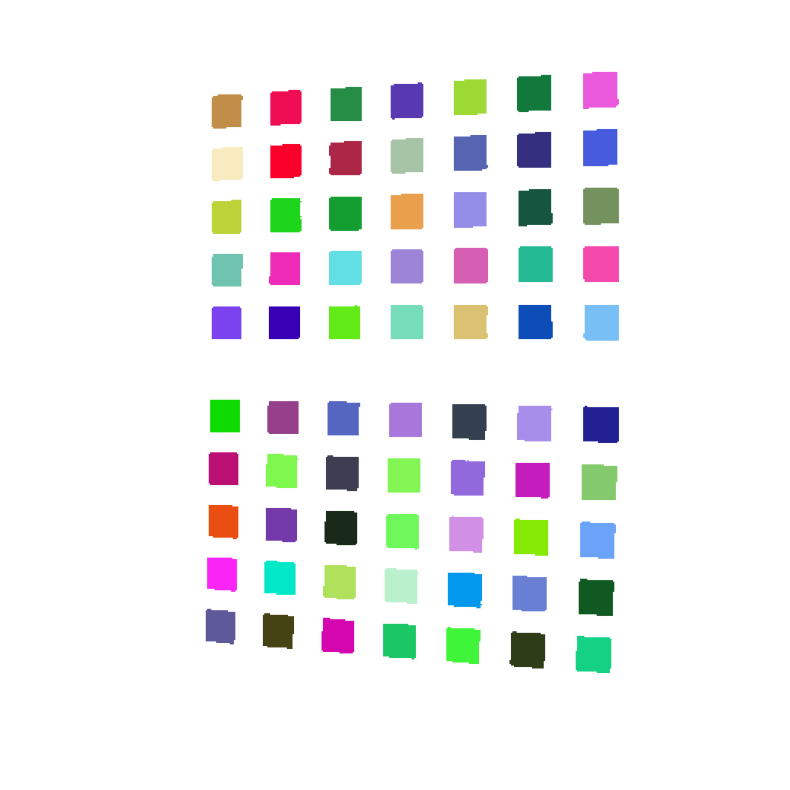

In [8]:
img = KMS.ShowMasks(Mask,(5,75))

## <center> CALCULO DE COLOR POR MASCARA RGB <center>

Se realiza un reordenamiento de las mascaras mediante la función sorted (se realiza dos veces este proceso, el primero es para obtener las mascaras con la menor area, donde se selecciona las muestras de interés al igual que en la sección anterior. La segunda ordenación se realiza para obtener la información espacial de acada una de las mascaras).

Posteriormente se realiza un promedio de color (LAB y RGB) de cada una de las mascaras mediante la función ***Lab_masks_RGB*** y la información se almacena en las variables ***Lab_masks y RGB_masks***.


Para el calculo de color se implementa la Matriz sRGB + D65 como referencia de blanco, es importante que la imagen RGB esté previamente **Normalizada**.

In [ ]:
sorted_anns = sorted(Mask, key=(lambda x: x['area']), reverse=True)[-76:-6]
sorted_anns_by_cords = sorted(sorted_anns, key=(lambda x: x['point_coords']), reverse=True)[::-1]
Lab_masks, idx, RGB_masks = KMS.Lab_masks_RGB(img = rgb_normal.reshape(-1,3), Masks = sorted_anns_by_cords)
print("Valores de blanco de referencia: " + str(mean))

## <center> CALCULO DE COLOR POR MASCARA HSI <center>

En primera instancia se aplican las mascaras geometricas generadas mediante la imagen **RGB** a la imagen **HSI** y posteriormente se realiza un reordenamiento de las mascaras mediante la función sorted (se realiza dos veces este proceso, el primero es para obtener las mascaras con la menor area, donde se selecciona las muestras de interés al igual que en la sección anterior. La segunda ordenación se realiza para obtener la información espacial de acada una de las mascaras).

En segunda intancia se realiza un analisis de blanco en la imagen mediante la función ***White_reference*** el cual extrae los valores trieestimulo **XYZ**
de la referencia de blanco para poder calcular el color en la imagen. Posteriormente se realiza un promedio de color (LAB y RGB) de cada una de las mascaras mediante la función ***Lab_masks_RGB*** y la información se almacena en las variables ***Lab_masks y RGB_masks*** mediante la función ***Lab_masks_HSI*** la cual depende de la imagen RGB, HSI, las mascaras y la referencia de blanco.


Para el calculo de color se **D65** como referencia de iluminante.

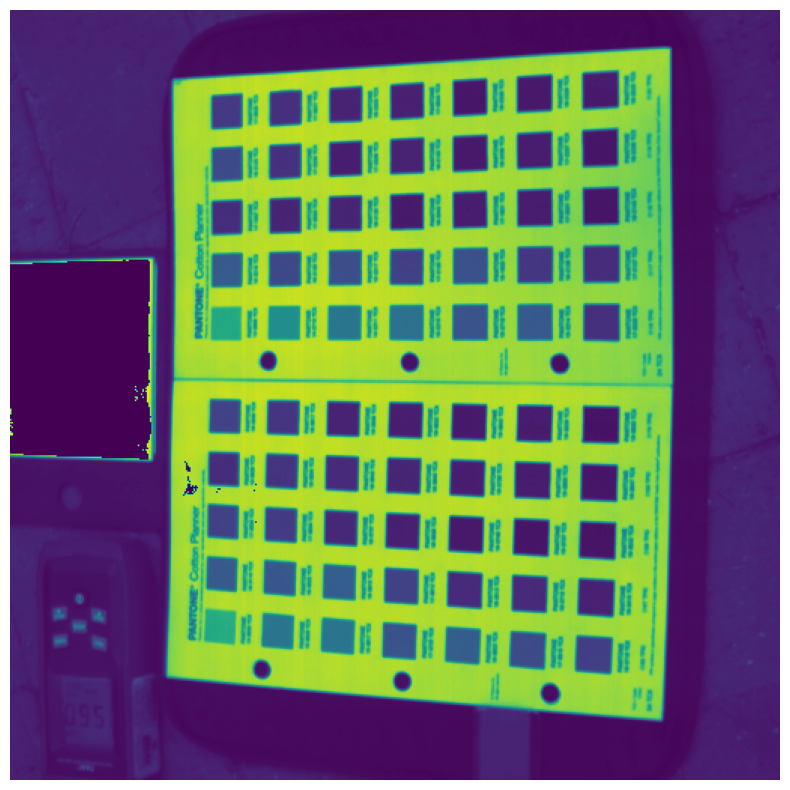

Valores de blanco de referencia: (0.9445221510848116, 0.9988167910133334, 1.082613084227547)


In [11]:
idx = np.where(img.reshape(-1,4) == [1,1,1,0])[0]
uhsi[idx] = np.zeros(204)

sorted_anns = sorted(Mask, key=(lambda x: x['area']), reverse=True)[-75:-5]
sorted_anns_by_cords = sorted(sorted_anns, key=(lambda x: x['point_coords']), reverse=True)[::-1]

White,_ = KMS.White_reference(hsi.reshape(-1,204),stdlim = 0.05)
print("Valores de blanco de referencia: "+str(White))

In [13]:
Lab_masks, idx, RGB_masks = KMS.Lab_masks_HSI(img = uhsi, Masks = sorted_anns_by_cords,rgb = urgb,White = White)